# Semantic Role Labeling

In [1]:
import os

In [2]:
os.chdir("../")

In [3]:
%pwd

'/Users/macbookpro/Documents/Documents - Macbook’s MacBook Pro/career/career_chief_rep'

# Config.yaml

# Entity

In [4]:
from dataclasses import dataclass
from pathlib import Path
from typing import List, Dict, Any

@dataclass
class SemanticRoleLabelingConfig:
    root_dir: Path
    data_path: Path
    output_path: Path
    model_path: str


# Configuration Manager

In [5]:
from src.career_chief.constants import *
from src.career_chief.utils.common import read_yaml, create_directories
from src.career_chief import logger
from src.career_chief.entity.config_entity import (SemanticRoleLabelingConfig)

class ConfigurationManager:
    """
    ConfigurationManager manages configurations needed for the data pipeline.

    The class reads configuration, parameter, and schema settings from specified files
    and provides a set of methods to access these settings. It also takes care of
    creating necessary directories defined in the configurations.

    Attributes:
    - config (dict): Configuration settings.
    - params (dict): Parameters for the pipeline.
    - schema (dict): Schema information.
    """
    
    def __init__(self, 
                 config_filepath = CONFIG_FILE_PATH, 
                 params_filepath = PARAMS_FILE_PATH, 
                 schema_filepath = SCHEMA_FILE_PATH) -> None:
        """
        Initialize ConfigurationManager with configurations, parameters, and schema.

        Args:
        - config_filepath (Path): Path to the configuration file.
        - params_filepath (Path): Path to the parameters file.
        - schema_filepath (Path): Path to the schema file.

        Creates:
        - Directories specified in the configuration.
        """
        self.config = self._read_config_file(config_filepath, "config")
        self.params = self._read_config_file(params_filepath, "params")
        self.schema = self._read_config_file(schema_filepath, "schema")

        # Create the directory for storing artifacts if it doesn't exist
        create_directories([self.config.artifacts_root])

    def _read_config_file(self, filepath: str, config_name: str) -> dict:
        """
        Read a configuration file and return its content.

        Args:
        - filepath (str): Path to the configuration file.
        - config_name (str): Name of the configuration (for logging purposes).

        Returns:
        - dict: Configuration settings.

        Raises:
        - Exception: If there's an error reading the file.
        """
        try:
            return read_yaml(filepath)
        except Exception as e:
            logger.error(f"Error reading {config_name} file: {filepath}. Error: {e}")
            raise

    
    def get_semantic_role_labeling_config(self) -> SemanticRoleLabelingConfig:
        
        try:
            semantic_role_labeling_config = self.config['semantic_role_labeling']
            
            return SemanticRoleLabelingConfig(
                root_dir=Path(semantic_role_labeling_config['root_dir']),
                data_path=Path(semantic_role_labeling_config['data_path']),
                output_path=Path(semantic_role_labeling_config['output_path']),
                model_path=semantic_role_labeling_config['model_path']
            )
        except KeyError as e:
            logger.error(f"A required configuration is missing in the 'semantic_role_labeling_config' section: {e}")
            raise KeyError(f"Missing configuration in 'semantic_role_labeling_config': {e}") from e

# Component

In [6]:
import pandas as pd
from tqdm import tqdm
from src.career_chief import logger
from allennlp_models.pretrained import load_predictor

class SemanticRoleLabelingComponent:
    """
    A component for semantic role labeling using a pretrained model from AllenNLP.
    This class provides functionality to predict semantic roles of sentences and process
    the outputs into a human-readable format, expanded to include detailed categories such as 
    temporal and quantitative expressions, skills, and organizational roles.

    Attributes:
        config: Configuration object containing paths for data and output.
        predictor: AllenNLP predictor for semantic role labeling.
    """
    def __init__(self, config):
        """
        Initializes the Semantic Role Labeling component with necessary configurations and model.
        Args:
            config: A configuration object with attributes like model_path, data_path, and output_path.
        """
        self.config = config
        self.predictor = load_predictor("structured-prediction-srl")
        logger.info("Semantic Role Labeling predictor loaded successfully.")

    def predict(self, sentence: str) -> dict:
        """
        Predicts the semantic roles of a given sentence.
        Args:
            sentence: A string containing the input sentence for semantic role labeling.
        Returns:
            A dictionary containing the predicted semantic roles.
        """
        return self.predictor.predict(sentence)

    def process_output(self, model_output: dict) -> dict:
        """
        Processes the raw model output to format it into a readable dictionary structure,
        categorizing semantic roles into structured categories.
        Args:
            model_output: A dictionary output from the semantic role labeling model.
        Returns:
            A dictionary with words and their associated roles formatted in a categorized way.
        """
        words = model_output["words"]
        verbs = model_output["verbs"]
        formatted_output = {
            "words": words,
            "verbs": []
        }
        for verb in verbs:
            tags = verb["tags"]
            roles = self.extract_roles(words, tags)
            formatted_output["verbs"].append({
                "verb": verb["verb"],
                "roles": roles
            })
        return formatted_output

    def extract_roles(self, words, tags, verbose=False):
        """
        Extracts detailed semantic roles based on BIO tags.
        Args:
            words: A list of words from the SRL output.
            tags: A list of BIO tags corresponding to each word.
            verbose: Boolean, if True, print the tags as they are processed.
        Returns:
            A dictionary categorizing words into detailed semantic roles.
        """
        roles = {}
        current_role = None
        current_content = []

        for word, tag in zip(words, tags):
            # Optional printing for debugging
            if verbose:
                print(f"Processing word: '{word}' with tag: '{tag}'")

            # Log each tag processed
            logger.debug(f"Processing word: '{word}' with tag: '{tag}'")

            # Check if the tag is correctly formatted and split safely
            if '-' in tag:
                tag_type, role = tag.split('-', 1)  # Split on the first hyphen only
            else:
                tag_type, role = 'O', None  # Treat as outside any entity

            if tag_type in ['B', 'I'] and (current_role != role):
                if current_content:
                    # Save the current role content
                    if current_role:  # Ensure there's an existing role to save
                        roles.setdefault(current_role, []).append(' '.join(current_content))
                # Start a new role
                current_role = role
                current_content = [word]
            elif tag_type == 'I' and current_role == role:
                # Continue the same role
                current_content.append(word)
            else:
                # Outside any role or different role starts without a 'B-'
                if current_content and current_role:
                    roles.setdefault(current_role, []).append(' '.join(current_content))
                current_role = None
                current_content = []

        # Add the last captured role if any
        if current_content and current_role:
            roles.setdefault(current_role, []).append(' '.join(current_content))

        return roles

    def run(self, num_jobs=None):
        """
        Processes a dataset to perform semantic role labeling.
        Args:
            num_jobs: Optional; number of job descriptions to process. If None, process all data.
        """
        logger.info("Reading data from {}".format(self.config.data_path))
        df = pd.read_csv(self.config.data_path)

        if num_jobs is not None:
            df = df.head(num_jobs)

        logger.info(f"Starting semantic role labeling for {len(df)} job descriptions.")
        tqdm.pandas(desc="Processing Semantic Role Labeling")
        df['srl_results'] = df['cleaned_text'].progress_apply(self.predict)
        df['processed_srl_results'] = df['srl_results'].apply(self.process_output)

        output_file_path = os.path.join(self.config.output_path, 'srl_results.csv')
        df.to_csv(output_file_path, index=False)
        logger.info(f"Results saved to {output_file_path}")



/Users/macbookpro/miniconda3/envs/career_chief_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/macbookpro/miniconda3/envs/career_chief_env/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/macbookpro/miniconda3/envs/career_chief_env/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/macbookpro/miniconda3/envs/career_chief_env/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: /Users/macbookpro/miniconda3/envs/career_chief_env/lib/python3.8

# Pipeline

In [7]:
from src.career_chief import logger
from src.career_chief.config.configuration import ConfigurationManager

# from src.career_chief.components.semantic_role_labeling import SemanticRoleLabelingComponent

class SemanticRoleLabellingPipeline:
    """
    Pipeline class for executing Semantic Role Labeling (SRL) on textual data.

    This pipeline is designed to facilitate the extraction of semantic roles
    from text which involves identifying the predicate-argument structure of sentences.
    It utilizes the SemanticRoleLabelingComponent to process the data.
    """

    STAGE_NAME = "Semantic Role Labeling Pipeline"

    def __init__(self):
        """
        Initializes the pipeline with the ConfigurationManager instance
        to access the necessary configurations for SRL processing.
        """
        self.config_manager = ConfigurationManager()
        logger.info(f"{self.STAGE_NAME} initialized successfully.")

    def run_semantic_role_labelling(self):
        """
        Runs the semantic role labeling process.

        This method orchestrates the loading of configurations, initialization of the
        SRL componenBVCXt, and executing the SRL process on the specified dataset.
        It handles and logs any exceptions that occur during the process.
        """
        try:
            logger.info(f"{self.STAGE_NAME}: Fetching configuration for Semantic Role Labeling.")
            srl_config = self.config_manager.get_semantic_role_labeling_config()

            logger.info(f"{self.STAGE_NAME}: Initializing the Semantic Role Labeling Component.")
            srl_component = SemanticRoleLabelingComponent(config=srl_config)

            logger.info(f"{self.STAGE_NAME}: Starting Semantic Role Labeling process.")
            # srl_component.run()
            # srl_component.testing()
            # Example usage
            # srl_component.run('eyJqb2JfdGl0bGUiOiJTZW5pb3IgRGF0YSBBbmFseXN0IiwiaHRpZG9jaWQiOiJ3TE5jRk9JRElGQUFBQUFBQUFBQUFBPT0iLCJ1dWxlIjoidytDQUlRSUNJTlZXNXBkR1ZrSUZOMFlYUmxjdyIsImdsIjoidXMiLCJobCI6ImVuIiwiZmMiOiJFdmNCQ3JjQlFVVnpOMnBPVW5NMU4yVjFkWGR5T1RNeFZGcG9jalE0YTJwb1UxTlBla0pyY0hWaldEZ3lXa3hxZUVaQ2JURkdZbXBNYVRVM2IwOU1VM2xZT0VWUlRHY3hRMlZmVkhwYVkxOUlaMDh4VFZoUGRGVnBOVkJ6U0VVNE16VlFSVUpaUWpOcE5tWjNaRkl6Y3pGNWNrMXJOVEppVUVOUFpXVmlTbmxQVkd0TVdrTlNlbWMwTFZseWFrMTVkbk5TZGxwQlNpMDNSekZ4YlVwMlluWnVhMlZ5TkdKVmNqUmZNMFJmU2tOaE1YcFJSa1I0V25CNGFrRjNFaGRRTjJSYVdrOVhjRWx6WlhsclpGVlFkRFJIWm0xQlZSb2lRVTh0TUhKc05XSmlTMHhSYVZCcE5FRk1TbVJLU0U4NGJpMXlWbE4wYWxkUlFRIiwiZmN2IjoiMyIsImZjX2lkIjoiZmNfNSIsImFwcGx5X2xpbmsiOnsidGl0bGUiOiJBcHBseSBvbiBKb2JMZWFkcyIsImxpbmsiOiJodHRwczovL3d3dy5qb2JsZWFkcy5jb20vZW4tdXMvam9iL2VmNmQwMjcxYmFiOWNjMDViZDExOGUzY2ZjOGQzMTUwZD91dG1fY2FtcGFpZ249Z29vZ2xlX2pvYnNfYXBwbHlcdTAwMjZ1dG1fc291cmNlPWdvb2dsZV9qb2JzX2FwcGx5XHUwMDI2dXRtX21lZGl1bT1vcmdhbmljIn19')
            srl_component.run(num_jobs=100)
            logger.info(f"{self.STAGE_NAME}: Semantic Role Labeling process completed successfully.")

        except Exception as e:
            logger.error(f"{self.STAGE_NAME}: Error occurred - {str(e)}")
            raise e

if __name__ == '__main__':
    pipeline = SemanticRoleLabellingPipeline()
    pipeline.run_semantic_role_labelling()


[2024-04-23 10:25:03,875: 41: career_chief_logger: INFO: common:  yaml file: config/config.yaml loaded successfully]


[2024-04-23 10:25:03,878: 41: career_chief_logger: INFO: common:  yaml file: params.yaml loaded successfully]
[2024-04-23 10:25:03,882: 41: career_chief_logger: INFO: common:  yaml file: schema.yaml loaded successfully]
[2024-04-23 10:25:03,882: 64: career_chief_logger: INFO: common:  Created directory at: artifacts]
[2024-04-23 10:25:03,883: 23: career_chief_logger: INFO: 1934440801:  Semantic Role Labeling Pipeline initialized successfully.]
[2024-04-23 10:25:03,883: 34: career_chief_logger: INFO: 1934440801:  Semantic Role Labeling Pipeline: Fetching configuration for Semantic Role Labeling.]
[2024-04-23 10:25:03,883: 37: career_chief_logger: INFO: 1934440801:  Semantic Role Labeling Pipeline: Initializing the Semantic Role Labeling Component.]
[2024-04-23 10:25:04,724: 96: allennlp.common.plugins: INFO: plugins:  Plugin allennlp_models available]
[2024-04-23 10:25:04,766: 221: allennlp.common.params: INFO: params:  id = vgqa-vilbert]
[2024-04-23 10:25:04,767: 221: allennlp.common.p

Processing Semantic Role Labeling: 100%|██████████| 100/100 [10:58<00:00,  6.59s/it]


[2024-04-23 10:36:14,690: 132: career_chief_logger: INFO: 2792070423:  Results saved to artifacts/model_training/allennlp-models/output/srl_results.csv]
[2024-04-23 10:36:15,378: 46: career_chief_logger: INFO: 1934440801:  Semantic Role Labeling Pipeline: Semantic Role Labeling process completed successfully.]


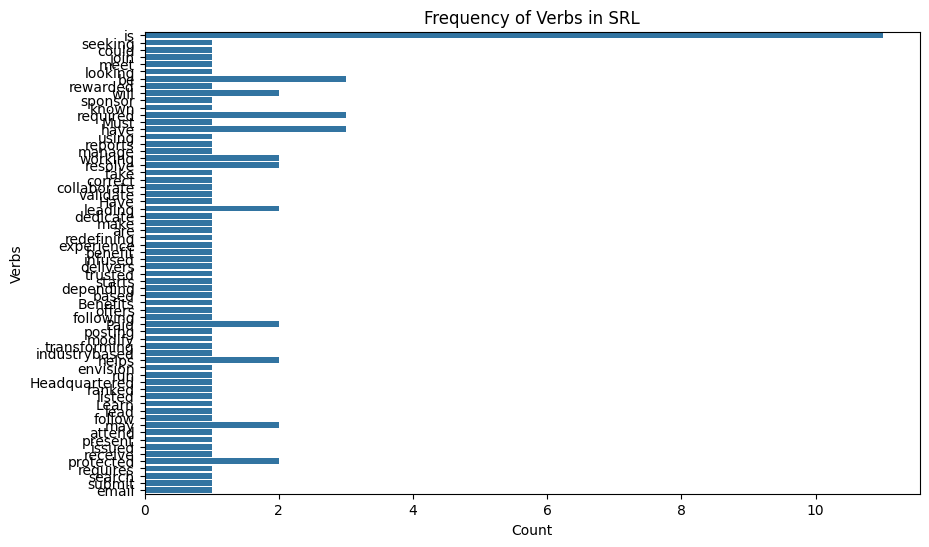

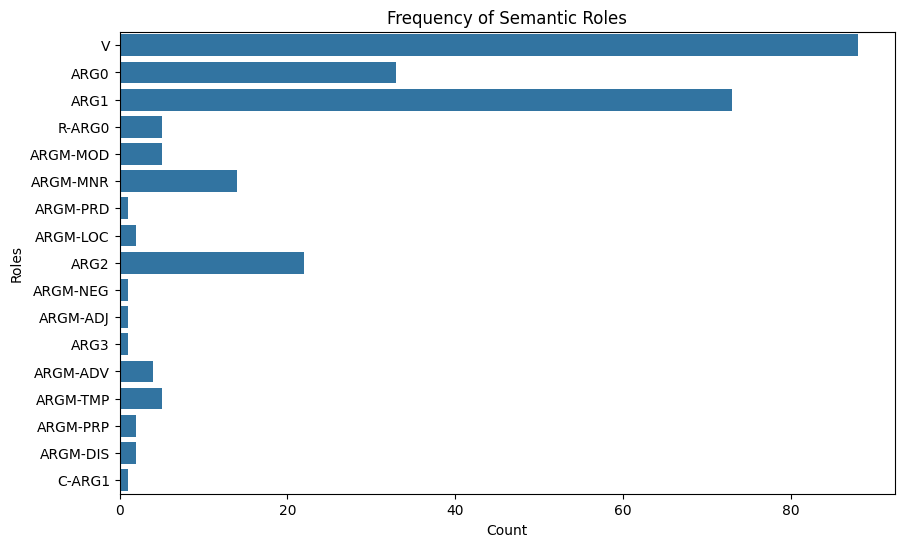

----
['is', 'seeking', 'could', 'join', 'meet', 'looking', 'be', 'rewarded', 'is', 'will', 'sponsor', 'known', 'required', 'Must', 'have', 'using', 'reports', 'have', 'manage', 'working', 'resolve', 'take', 'correct', 'collaborate', 'resolve', 'validate', 'Have', 'is', 'leading', 'is', 'dedicate', 'working', 'make', 'are', 'redefining', 'experience', 'benefit', 'is', 'infused', 'delivers', 'trusted', 'starts', 'depending', 'is', 'based', 'Benefits', 'offers', 'following', 'Paid', 'Paid', 'is', 'posting', 'modify', 'is', 'leading', 'transforming', 'industrybased', 'helps', 'envision', 'run', 'Headquartered', 'is', 'ranked', 'is', 'listed', 'Learn', 'helps', 'lead', 'follow', 'may', 'be', 'required', 'attend', 'may', 'be', 'required', 'present', 'issued', 'is', 'will', 'receive', 'protected', 'protected', 'have', 'requires', 'search', 'submit', 'email']
----
[88 33 73  5  5 14  1  2 22  1  1  1  4  5  2  2  1] Index(['V', 'ARG0', 'ARG1', 'R-ARG0', 'ARGM-MOD', 'ARGM-MNR', 'ARGM-PRD',
    

In [8]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

def safe_load_json(json_str):
    """Attempts to convert single quotes to double quotes and load JSON data safely."""
    try:
        return json.loads(json_str)
    except json.JSONDecodeError:
        # Try fixing common JSON errors by replacing single quotes with double quotes
        try:
            json_str = json_str.replace("'", '"')
            return json.loads(json_str)
        except json.JSONDecodeError as e:
            print(f"Failed to decode JSON: {e}")
            return {}  # Return empty dict if still fails

def extract_verb_roles(df):
        """
        Extracts verbs and their associated roles from the DataFrame loaded from the CSV.
        
        Returns:
            tuple: Contains a list of verbs, a dictionary of roles, and relationships.
        """
        verbs = []
        roles_dict = {}
        relationships = []
        for _, row in df.iterrows():
            srl_data = safe_load_json(row['processed_srl_results'])
            for verb_info in srl_data.get('verbs', []):
                verb = verb_info.get('verb')
                verbs.append(verb)
                for role, content in verb_info.get('roles', {}).items():
                    if role not in roles_dict:
                        roles_dict[role] = []
                    roles_dict[role].extend(content if isinstance(content, list) else [content])
                    relationships.append((verb, role))
        return verbs, roles_dict, relationships

def visualize_data(verbs, roles_dict):
    """Visualize the frequency of verbs and roles using bar charts."""
    plt.figure(figsize=(10, 6))
    sns.countplot(y=verbs)
    plt.title('Frequency of Verbs in SRL')
    plt.xlabel('Count')
    plt.ylabel('Verbs')
    plt.show()

    plt.figure(figsize=(10, 6))
    role_counts = {role: len(contents) for role, contents in roles_dict.items()}
    roles_series = pd.Series(role_counts)
    sns.barplot(x=roles_series.values, y=roles_series.index)
    plt.title('Frequency of Semantic Roles')
    plt.xlabel('Count')
    plt.ylabel('Roles')
    plt.show()

def load_srl_data(file_path):
    """Load the SRL results from a CSV file."""
    return pd.read_csv(file_path)

def main():
    file_path = 'artifacts/model_training/allennlp-models/output/srl_results.csv'
    df = load_srl_data(file_path)
    verbs, roles_dict, relationships = extract_verb_roles(df)
    visualize_data(verbs, roles_dict)
    print("----")
    print(verbs)
    print("----")
    role_counts = {role: len(contents) for role, contents in roles_dict.items()}
    roles_series = pd.Series(role_counts)
    print(roles_series.values,roles_series.index)
    # print(roles_dict)
    # print(df.head())

if __name__ == "__main__":
    main()


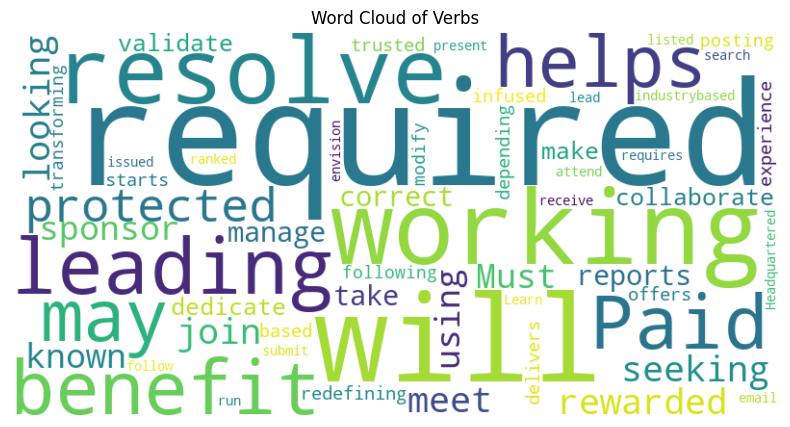

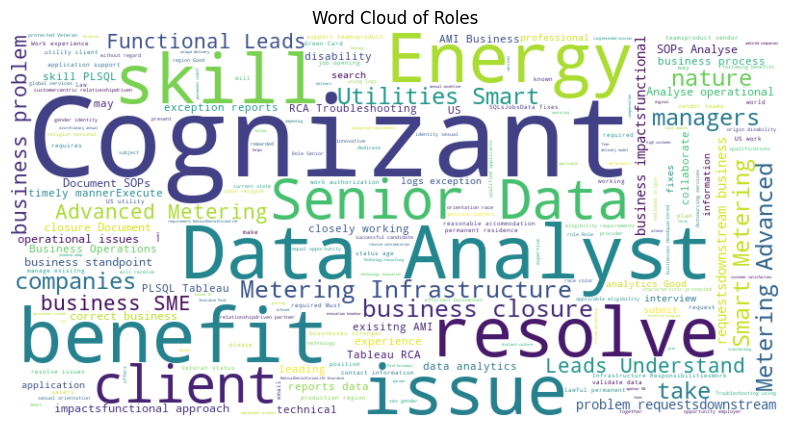

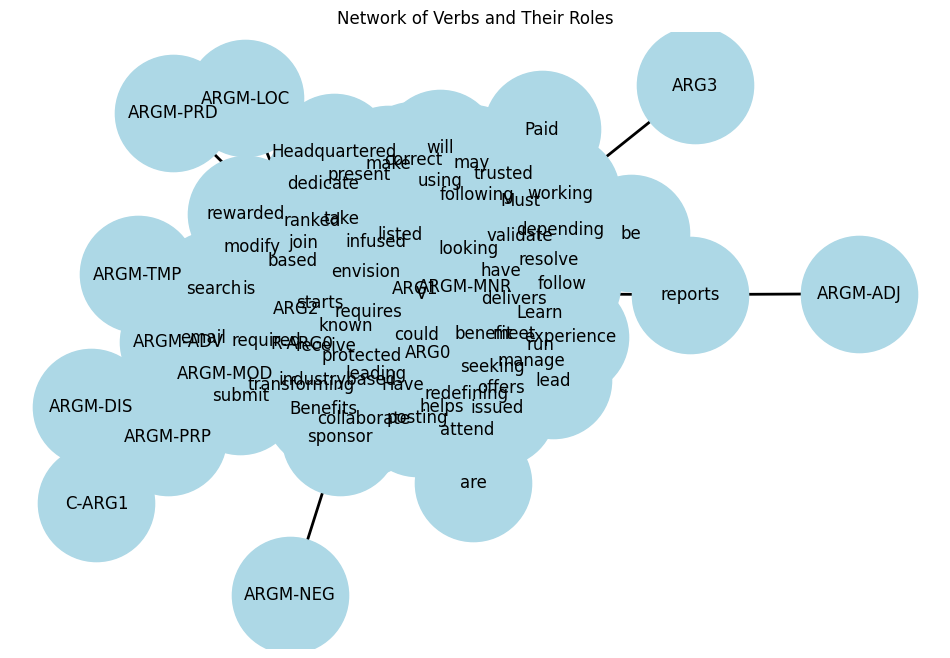

In [9]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import networkx as nx

class SRLVisualization:
    """Class to process and visualize Semantic Role Labeling (SRL) results."""

    def __init__(self, file_path):
        """Initialize with the path to the data file."""
        self.file_path = file_path
        self.df = self.load_srl_data()

    def safe_load_json(self, json_str):
        """Attempts to load JSON data safely with common string fix."""
        try:
            return json.loads(json_str)
        except json.JSONDecodeError:
            try:
                json_str = json_str.replace("'", '"')
                return json.loads(json_str)
            except json.JSONDecodeError as e:
                print(f"Failed to decode JSON: {e}")
                return {}

    def extract_verb_roles(self, column='processed_srl_results'):
        """Extract verbs and their semantic roles."""
        verbs = []
        roles_dict = {}
        relationships = []
        for _, row in self.df.iterrows():
            srl_data = self.safe_load_json(row[column])
            for verb_info in srl_data.get('verbs', []):
                verb = verb_info.get('verb')
                verbs.append(verb)
                for role, content in verb_info.get('roles', {}).items():
                    if role not in roles_dict:
                        roles_dict[role] = []
                    roles_dict[role].extend(content if isinstance(content, list) else [content])
                    relationships.append((verb, role))
        return verbs, roles_dict, relationships

    def visualize_word_cloud(self, words, title):
        """Generate a word cloud from words."""
        wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(" ".join(words))
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(title)
        plt.axis("off")
        plt.show()

    def visualize_relationships(self, relationships):
        """Visualize relationships using a network diagram."""
        G = nx.Graph()
        G.add_edges_from(relationships)
        plt.figure(figsize=(12, 8))
        pos = nx.spring_layout(G, seed=7)  # positions for all nodes
        nx.draw_networkx_nodes(G, pos, node_size=7000, node_color="lightblue")
        nx.draw_networkx_edges(G, pos, width=2)
        nx.draw_networkx_labels(G, pos, font_size=12, font_family="sans-serif")
        plt.title('Network of Verbs and Their Roles')
        plt.axis("off")
        plt.show()

    def load_srl_data(self):
        """Load SRL results from a CSV file."""
        return pd.read_csv(self.file_path)

    def run(self):
        """Main method to extract data and generate visualizations."""
        verbs, roles_dict, relationships = self.extract_verb_roles()
        self.visualize_word_cloud(verbs, "Word Cloud of Verbs")
        self.visualize_word_cloud([item for sublist in roles_dict.values() for item in sublist], "Word Cloud of Roles")
        self.visualize_relationships(relationships)

if __name__ == "__main__":
    srl_vis = SRLVisualization('artifacts/model_training/allennlp-models/output/srl_results.csv')
    srl_vis.run()


is              11
required         3
be               3
have             3
Paid             2
helps            2
leading          2
resolve          2
may              2
working          2
will             2
protected        2
present          1
requires         1
offers           1
following        1
submit           1
posting          1
modify           1
transforming     1
Name: count, dtype: int64


/var/folders/7v/b_qdblv15hg0h789msb73v4r0000gn/T/ipykernel_6466/2160556735.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=verb_counts.index, x=verb_counts.values, palette='coolwarm')


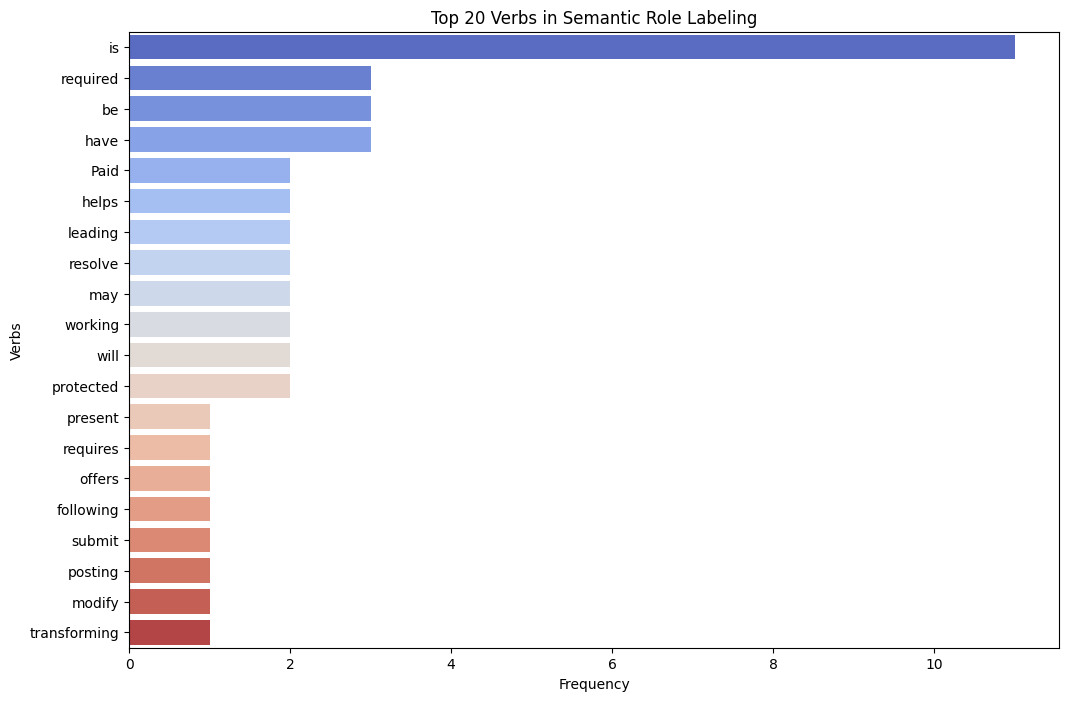

V           88
ARG0        33
ARG1        73
R-ARG0       5
ARGM-MOD     5
ARGM-MNR    14
ARGM-PRD     1
ARGM-LOC     2
ARG2        22
ARGM-NEG     1
ARGM-ADJ     1
ARG3         1
ARGM-ADV     4
ARGM-TMP     5
ARGM-PRP     2
ARGM-DIS     2
C-ARG1       1
dtype: int64


/var/folders/7v/b_qdblv15hg0h789msb73v4r0000gn/T/ipykernel_6466/2160556735.py:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=roles_series.values, y=roles_series.index, palette='coolwarm')


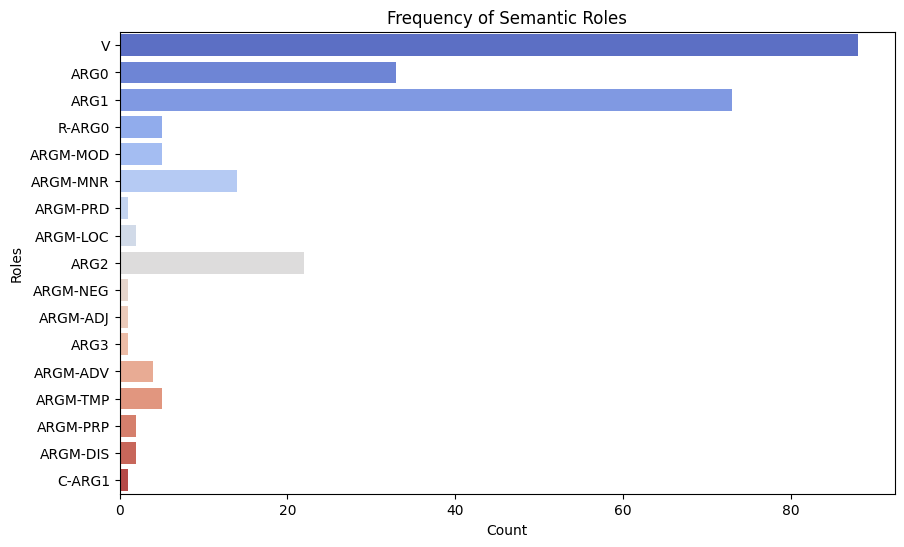

['is', 'V', 'seeking', 'ARG0', 'ARG1', 'could', 'R-ARG0', 'join', 'ARGM-MOD', 'ARGM-MNR', 'ARGM-PRD', 'ARGM-LOC', 'meet', 'looking', 'be', 'rewarded', 'ARG2', 'will', 'sponsor', 'ARGM-NEG', 'known', 'required', 'Must', 'have', 'using', 'reports', 'ARGM-ADJ', 'manage', 'working', 'resolve', 'take', 'correct', 'collaborate', 'validate', 'Have', 'leading', 'dedicate', 'ARG3', 'make', 'are', 'redefining', 'experience', 'benefit', 'infused', 'delivers', 'trusted', 'starts', 'ARGM-ADV', 'depending', 'based', 'Benefits', 'offers', 'following', 'Paid', 'ARGM-TMP', 'posting', 'modify', 'transforming', 'ARGM-PRP', 'industrybased', 'helps', 'envision', 'run', 'Headquartered', 'ranked', 'listed', 'Learn', 'lead', 'follow', 'may', 'attend', 'present', 'issued', 'receive', 'protected', 'requires', 'search', 'submit', 'ARGM-DIS', 'C-ARG1', 'email']
[('is', 'V'), ('is', 'ARG1'), ('is', 'ARG2'), ('is', 'ARGM-ADV'), ('is', 'ARGM-TMP'), ('V', 'seeking'), ('V', 'could'), ('V', 'join'), ('V', 'meet'), ('V'

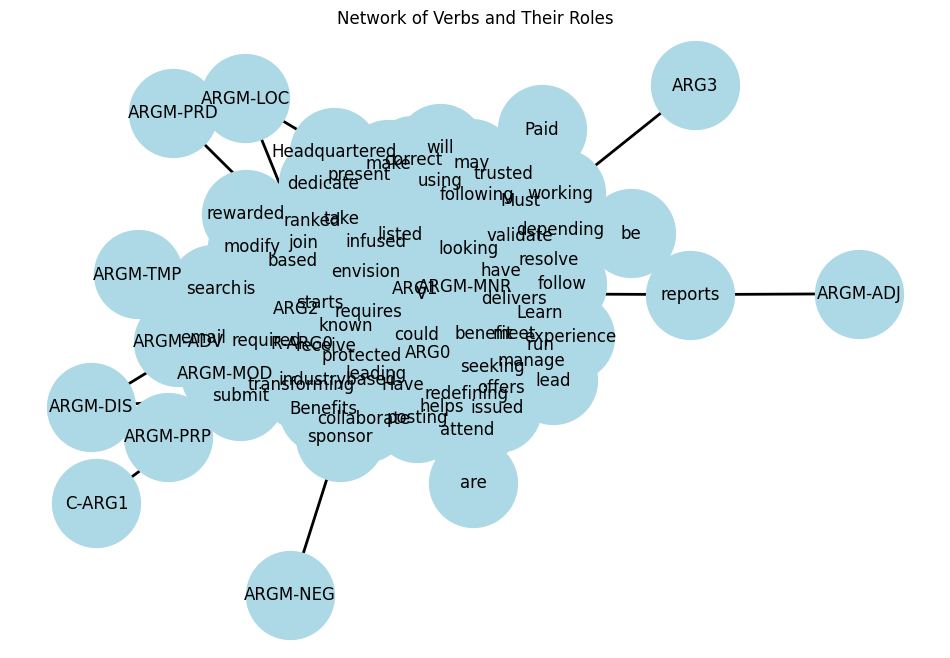

In [10]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

class SRLVisualization:
    """Class to visualize Semantic Role Labeling (SRL) results from a CSV file."""

    def __init__(self, file_path):
        """Initialize the visualization class with the path to the SRL results file."""
        self.file_path = file_path
        self.df = self.load_srl_data()

    def safe_load_json(self, json_str):
        """
        Safely loads a JSON string, attempting to fix common errors in formatting.
        
        Args:
            json_str (str): JSON string to parse.
        
        Returns:
            dict: Parsed JSON data.
        """
        try:
            return json.loads(json_str)
        except json.JSONDecodeError:
            try:
                json_str = json_str.replace("'", '"')
                return json.loads(json_str)
            except json.JSONDecodeError as e:
                print(f"Failed to decode JSON: {e}")
                return {}

    def extract_verb_roles(self):
        """
        Extracts verbs and their associated roles from the DataFrame loaded from the CSV.
        
        Returns:
            tuple: Contains a list of verbs, a dictionary of roles, and relationships.
        """
        verbs = []
        roles_dict = {}
        relationships = []
        for _, row in self.df.iterrows():
            srl_data = self.safe_load_json(row['processed_srl_results'])
            for verb_info in srl_data.get('verbs', []):
                verb = verb_info.get('verb')
                verbs.append(verb)
                for role, content in verb_info.get('roles', {}).items():
                    if role not in roles_dict:
                        roles_dict[role] = []
                    roles_dict[role].extend(content if isinstance(content, list) else [content])
                    relationships.append((verb, role))
        return verbs, roles_dict, relationships

    def visualize_top_verbs_and_roles(self, verbs, roles_dict):
        """
        Visualizes the top 20 verbs and the frequency of semantic roles.
        
        Args:
            verbs (list): List of verbs to visualize.
            roles_dict (dict): Dictionary of roles associated with the verbs.
        """
        verb_counts = pd.Series(verbs).value_counts().nlargest(20)
        print(verb_counts)
        plt.figure(figsize=(12, 8))
        sns.barplot(y=verb_counts.index, x=verb_counts.values, palette='coolwarm')
        plt.title('Top 20 Verbs in Semantic Role Labeling')
        plt.xlabel('Frequency')
        plt.ylabel('Verbs')
        plt.show()

        role_counts = {role: len(contents) for role, contents in roles_dict.items()}
        roles_series = pd.Series(role_counts)
        print(roles_series)
        plt.figure(figsize=(10, 6))
        sns.barplot(x=roles_series.values, y=roles_series.index, palette='coolwarm')
        plt.title('Frequency of Semantic Roles')
        plt.xlabel('Count')
        plt.ylabel('Roles')
        plt.show()

    def visualize_relationships(self, relationships):
        """
        Visualizes the relationships between verbs and roles using a network graph.
        
        Args:
            relationships (list of tuples): Pairs of verbs and roles.
        """
        G = nx.Graph()
        G.add_edges_from(relationships)
        print(G.nodes)
        print(G.edges)
        plt.figure(figsize=(12, 8))
        pos = nx.spring_layout(G, seed=7)
        nx.draw_networkx_nodes(G, pos, node_size=4000,  node_color="lightblue")
        nx.draw_networkx_edges(G, pos, width=2)
        nx.draw_networkx_labels(G, pos, font_size=12, font_family="sans-serif")
        plt.title('Network of Verbs and Their Roles')
        plt.axis("off")
        plt.show()

    def load_srl_data(self):
        """
        Loads SRL results from the specified CSV file.
        
        Returns:
            pd.DataFrame: Data loaded from the CSV file.
        """
        return pd.read_csv(self.file_path)

    def run(self):
        """
        Executes the extraction and visualization processes for the SRL results.
        """
        verbs, roles_dict, relationships = self.extract_verb_roles()
        self.visualize_top_verbs_and_roles(verbs, roles_dict)
        self.visualize_relationships(relationships)

if __name__ == "__main__":
    srl_vis = SRLVisualization('/Users/macbookpro/Documents/Documents - Macbook’s MacBook Pro/career/career_chief_rep/artifacts/model_training/allennlp-models/output/srl_results.csv')
    srl_vis.run()


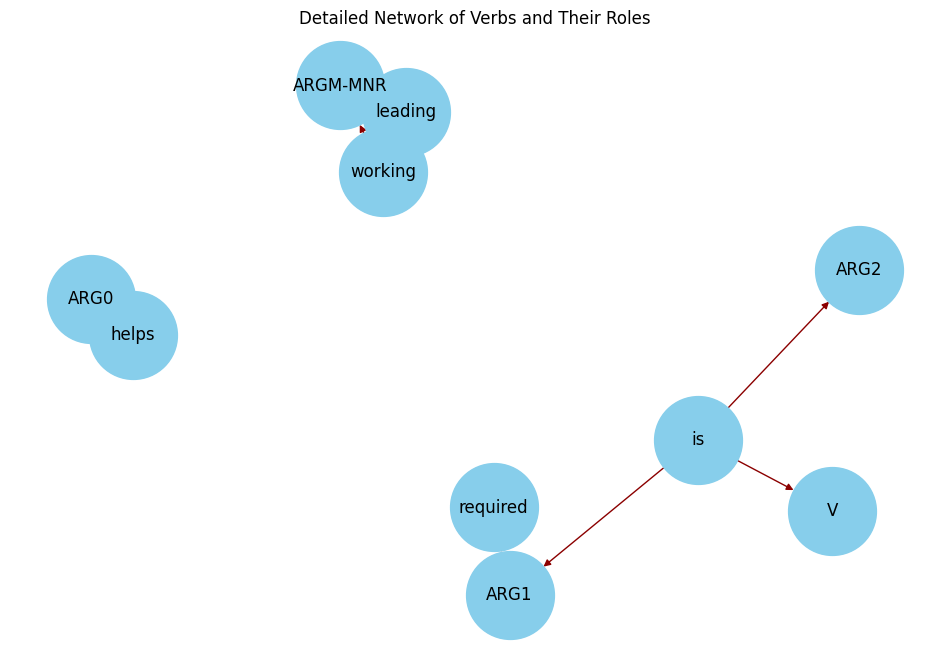

In [12]:
# Revised relationships data focusing on a few key roles for clarity
selected_relationships = [
    ('is', 'V'), ('is', 'ARG1'), ('is', 'ARG2'), ('helps', 'ARG0'), ('required', 'ARG1'), 
    ('working', 'ARGM-MNR'), ('leading', 'ARGM-MNR')
]

# Creating a network graph with the selected relationships
selected_G = nx.DiGraph()
selected_G.add_edges_from(selected_relationships)

# Redefining nodes to focus on specific roles
nodes_to_plot = ['is', 'V', 'ARG1', 'ARG2', 'helps', 'ARG0', 'required', 'working', 'leading', 'ARGM-MNR']

# All nodes extracted from relationships for guaranteed consistency
nodes = set()
for edge in selected_relationships:
    nodes.update(edge)

# Create the graph
G = nx.DiGraph()
G.add_nodes_from(nodes)  # Add all nodes explicitly
G.add_edges_from(selected_relationships)  # Add edges

# Plotting
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)  # positions for all nodes
nx.draw_networkx(G, pos, with_labels=True, node_color='skyblue', edge_color='darkred', node_size=4000, font_size=12)
plt.title('Detailed Network of Verbs and Their Roles')
plt.axis('off')  # Turn off the axis
plt.show()



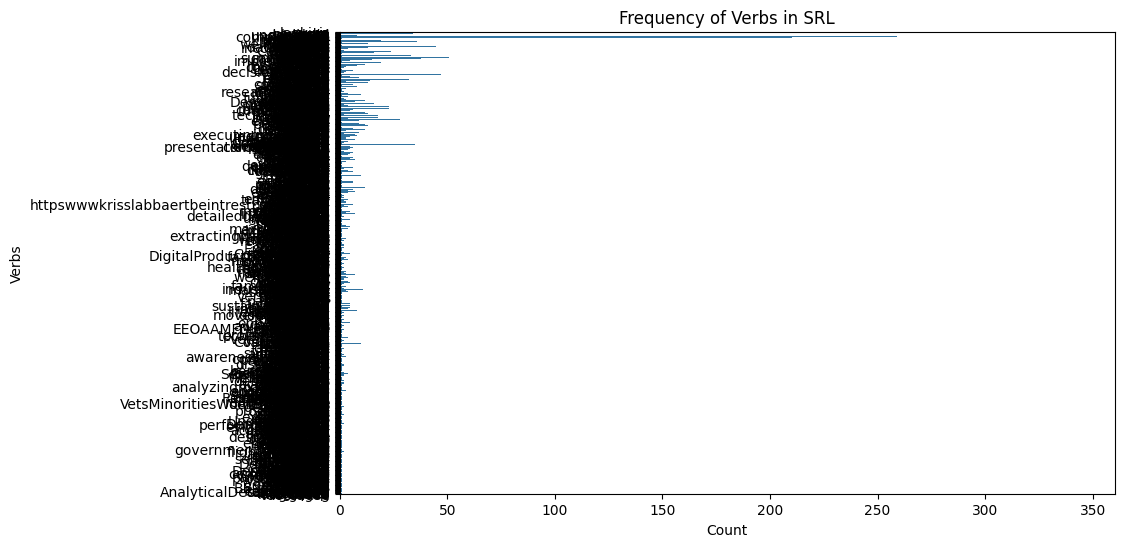

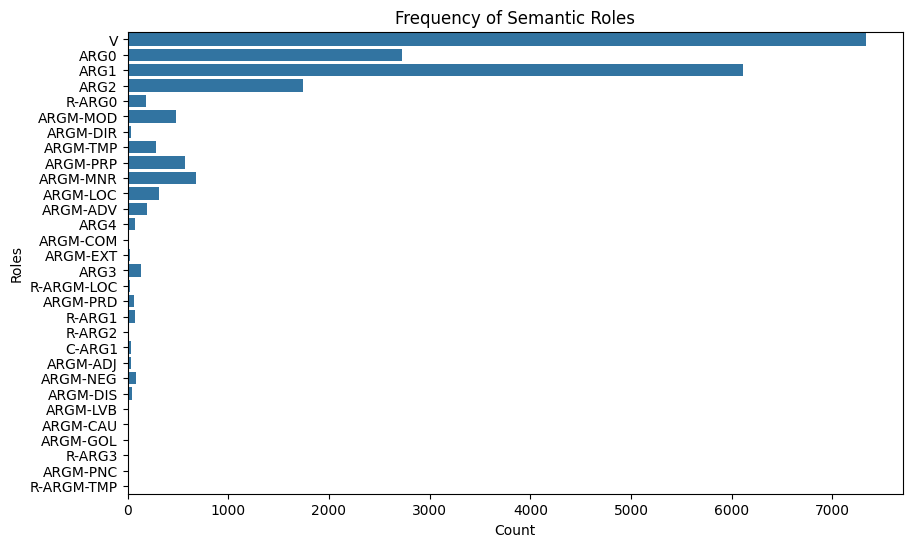

----
['is', 'looking', 'is', 'is', 'looking', 'can', 'turn', 'consults', 'understand', 'delivers', 'meet', 'is', 'captured', 'understood', 'defined', 'built', 'helps', 'optimize', 'complements', 'will', 'possess', 'navigate', 'understand', 'will', 'be', 'help', 'understand', 'generate', 'will', 'dig', 'processed', 'transform', 'using', 'articulate', 'involves', 'will', 'be', 'prioritize', 'perform', 'drive', 'inform', 'related', 'Develop', 'answer', 'welldesigned', 'using', 'optimize', 'learning', 'Oversee', 'define', 'map', 'create', 'define', 'reporting', 'support', 'thought', 'may', 'be', 'better', 'Drive', 'dataminded', 'Develop', 'ensure', 'can', 'be', 'incorporated', 'produce', 'generate', 'existing', 'Identify', 'required', 'tell', 'using', 'establish', 'monitor', 'decline', 'Contribute', 'enable', 'use', 'Serve', 'Help', 'create', 'maintain', 'required', 'manage', 'is', 'desired', 'working', 'Must', 'be', 'be', 'including', 'applying', 'drawing', 'making', 'define', 'understand

In [13]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

def safe_load_json(json_str):
    """Attempts to convert single quotes to double quotes and load JSON data safely."""
    try:
        return json.loads(json_str)
    except json.JSONDecodeError:
        # Try fixing common JSON errors by replacing single quotes with double quotes
        try:
            json_str = json_str.replace("'", '"')
            return json.loads(json_str)
        except json.JSONDecodeError as e:
            print(f"Failed to decode JSON: {e}")
            return {}  # Return empty dict if still fails

def extract_verb_roles(df):
        """
        Extracts verbs and their associated roles from the DataFrame loaded from the CSV.
        
        Returns:
            tuple: Contains a list of verbs, a dictionary of roles, and relationships.
        """
        verbs = []
        roles_dict = {}
        relationships = []
        for _, row in df.iterrows():
            srl_data = safe_load_json(row['processed_srl_results'])
            for verb_info in srl_data.get('verbs', []):
                verb = verb_info.get('verb')
                verbs.append(verb)
                for role, content in verb_info.get('roles', {}).items():
                    if role not in roles_dict:
                        roles_dict[role] = []
                    roles_dict[role].extend(content if isinstance(content, list) else [content])
                    relationships.append((verb, role))
        return verbs, roles_dict, relationships

def visualize_data(verbs, roles_dict):
    """Visualize the frequency of verbs and roles using bar charts."""
    plt.figure(figsize=(10, 6))
    sns.countplot(y=verbs)
    plt.title('Frequency of Verbs in SRL')
    plt.xlabel('Count')
    plt.ylabel('Verbs')
    plt.show()

    plt.figure(figsize=(10, 6))
    role_counts = {role: len(contents) for role, contents in roles_dict.items()}
    roles_series = pd.Series(role_counts)
    sns.barplot(x=roles_series.values, y=roles_series.index)
    plt.title('Frequency of Semantic Roles')
    plt.xlabel('Count')
    plt.ylabel('Roles')
    plt.show()

def load_srl_data(file_path):
    """Load the SRL results from a CSV file."""
    return pd.read_csv(file_path)

def main():
    file_path = 'artifacts/model_training/allennlp-models/output/srl_results.csv'
    df = load_srl_data(file_path)
    verbs, roles_dict, relationships = extract_verb_roles(df)
    visualize_data(verbs, roles_dict)
    print("----")
    print(verbs)
    print("----")
    role_counts = {role: len(contents) for role, contents in roles_dict.items()}
    roles_series = pd.Series(role_counts)
    print(roles_series.values,roles_series.index)
    # print(roles_dict)
    # print(df.head())

if __name__ == "__main__":
    main()


In [15]:
import pandas as pd

df_srl_results = pd.read_csv('artifacts/model_training/allennlp-models/output/srl_results.csv')

In [16]:
df_srl_results

,Unnamed: 0,index,title,company_name,location,via,description,extensions,job_id,thumbnail,...,salary_standardized,description_tokens,cleaned_text,tokens,ner_results,entities,topic,probability,srl_results,processed_srl_results
0,30200,827,Senior Data Analyst,Planet Technology,Anywhere,via LinkedIn,Our Client is looking for a full-time Sr. Data...,"['10 hours ago', 'Work from home', 'Full-time']",eyJqb2JfdGl0bGUiOiJTZW5pb3IgRGF0YSBBbmFseXN0Ii...,https://encrypted-tbn0.gstatic.com/images?q=tb...,...,NaN,"['excel', 'bigquery', 'redshift', 'sql', 'powe...",Our Client is looking for a fulltime Sr Data A...,"['Our', 'C', '##lient', 'is', 'looking', 'for'...","[{'entity': 'B-MISC', 'score': 0.6366868, 'ind...","[('Sr Data Analyst', 'Job Title'), ('Data Anal...",-1,0.000000,"{'verbs': [{'verb': 'is', 'description': 'Our ...","{'words': ['Our', 'Client', 'is', 'looking', '..."
1,13682,652,Data Analysis,Upwork,Anywhere,via Upwork,We are seeking a skilled data analyst to join ...,"['19 hours ago', 'Work from home', 'Contractor...",eyJqb2JfdGl0bGUiOiJEYXRhIEFuYWx5c2lzIiwiaHRpZG...,NaN,...,NaN,[],We are seeking a skilled data analyst to join ...,"['We', 'are', 'seeking', 'a', 'skilled', 'data...",[],[('make datadriven recommendations The ideal c...,7,1.000000,"{'verbs': [{'verb': 'are', 'description': 'We ...","{'words': ['We', 'are', 'seeking', 'a', 'skill..."
2,3935,1901,Google Analytics GA4 Adjustment,Upwork,Anywhere,via Upwork,We are seeking a skilled professional to adjus...,"['12 hours ago', '10–46 an hour', 'Work from h...",eyJqb2JfdGl0bGUiOiJHb29nbGUgQW5hbHl0aWNzIEdBNC...,NaN,...,58240.0,[],We are seeking a skilled professional to adjus...,"['We', 'are', 'seeking', 'a', 'skilled', 'prof...","[{'entity': 'B-MISC', 'score': 0.8648094, 'ind...","[('Google Analytics to', 'Job Title'), ('Googl...",0,1.000000,"{'verbs': [{'verb': 'are', 'description': 'We ...","{'words': ['We', 'are', 'seeking', 'a', 'skill..."
3,26125,2684,Data analyst sql and etl data management,Upwork,Anywhere,via Upwork,It's totally about data analysis and looking f...,"['14 hours ago', '8–15 an hour', 'Work from ho...",eyJqb2JfdGl0bGUiOiJEYXRhIGFuYWx5c3Qgc3FsIGFuZC...,NaN,...,23920.0,"['excel', 'sql']",Its totally about data analysis and looking fo...,"['Its', 'totally', 'about', 'data', 'analysis'...","[{'entity': 'B-MISC', 'score': 0.8927205, 'ind...","[('Data analyst', 'Job Title')]",-1,0.000000,"{'verbs': [{'verb': 'looking', 'description': ...","{'words': ['Its', 'totally', 'about', 'data', ..."
4,24366,925,Reporting and Data Enablement Analyst (Remote),Vail Resorts,Anywhere,via Indeed,As a leading mountain resort operator with ove...,"['16 hours ago', '82,800–106,425 a year', 'Wor...",eyJqb2JfdGl0bGUiOiJSZXBvcnRpbmcgYW5kIERhdGEgRW...,https://encrypted-tbn0.gstatic.com/images?q=tb...,...,94612.5,"['jira', 'python', 'atlassian', 'snowflake', '...",As a leading mountain resort operator with ove...,"['As', 'a', 'leading', 'mountain', 'resort', '...","[{'entity': 'B-MISC', 'score': 0.63972175, 'in...",[('building and maintaining strong culture bot...,-1,0.000000,"{'verbs': [{'verb': 'leading', 'description': ...","{'words': ['As', 'a', 'leading', 'mountain', '..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,20922,1317,"Senior Analyst, Business Intelligence",The J. M. Smucker Company,United States,via Professional Diversity Network,"TITLE\n\nSenior Analyst, Business Intelligence...","['20 hours ago', 'Full-time', 'Health insurance']",eyJqb2JfdGl0bGUiOiJTZW5pb3IgQW5hbHlzdCwgQnVzaW...,https://encrypted-tbn0.gstatic.com/images?q=tb...,...,NaN,"['javascript', 'power_bi', 'sql', 'html', 'css...",TITLE\n\nSenior Analyst Business Intelligence\...,"['T', '##IT', '##LE', 'Senior', 'Ana', '##ly',...",[],"[('Senior Analyst', 'Job Title'), ('Manager Bu...",88,0.793065,"{'verbs': [{'verb': 'Serves', 'description': '...","{'words': ['TITLE', 'Senior', 'Analyst', 'Busi..."
96,2146,112,"Analyst II, Data Analytics",Walmart,"Springdale, A